<a href="https://colab.research.google.com/github/edwin-19/recommend-sys/blob/main/Retrival_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install neccessary libraries
- Lets install tf recommender and scann
- From there lets settle some of our imports

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q scann

     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 10.6 MB 4.5 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from typing import Dict, Text

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pprint

# Preparing the dataset
- Lets download our dataset via tfds
- We are gonna use the moveielens dataset

In [3]:
ratings, info_ratings = tfds.load("movielens/100k-ratings", split="train", with_info=True)
# Features of all the available movies.
movies, info_movies = tfds.load("movielens/100k-movies", split="train", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incompleteI6VQ69/movielens-train.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-movies/0.1.0.incompleteBJWMF8/movielens-train.tfrecord


  0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


In [4]:
index_class = dict([(index, names) for index, names in enumerate(info_movies.features['movie_genres'].names)])

# EDA
- Lets try to understand a bit on the data

In [5]:
# Lets explore our data abit
movies_df = tfds.as_dataframe(movies, info_movies)
ratings_df = tfds.as_dataframe(ratings, info_ratings)

In [6]:
movies_df = movies_df.drop(index=9)

In [47]:
movies_df['label_genre'] = movies_df['movie_genres'].apply(lambda x: [index_class[d] for d in x])
ratings_df['label_genre'] = ratings_df['movie_genres'].apply(lambda x: [index_class[d] for d in x])
movies_df['years'] = movies_df['movie_title'].apply(lambda x: x.decode('utf-8').split('(')[-1][:-1])

In [8]:
movies_df.sample(10)

,movie_genres,movie_id,movie_title,label_genre,years
680,"[4, 13, 14, 16]",b'945',b'Charade (1963)',"[Comedy, Mystery, Romance, Thriller]",1963
139,"[0, 16]",b'295',b'Breakdown (1997)',"[Action, Thriller]",1997
706,[4],b'1172',"b'Women, The (1939)'",[Comedy],1939
137,"[4, 7]",b'34',"b'Doom Generation, The (1995)'","[Comedy, Drama]",1995
1048,[7],b'1149',b'Walkabout (1971)',[Drama],1971
867,"[4, 14]",b'70',b'Four Weddings and a Funeral (1994)',"[Comedy, Romance]",1994
1020,"[7, 19]",b'1004',b'Geronimo: An American Legend (1993)',"[Drama, Western]",1993
20,"[1, 15, 16]",b'355',b'Sphere (1998)',"[Adventure, Sci-Fi, Thriller]",1998
337,[7],b'697',"b'Basketball Diaries, The (1995)'",[Drama],1995
1555,[4],b'369',b'Black Sheep (1996)',[Comedy],1996


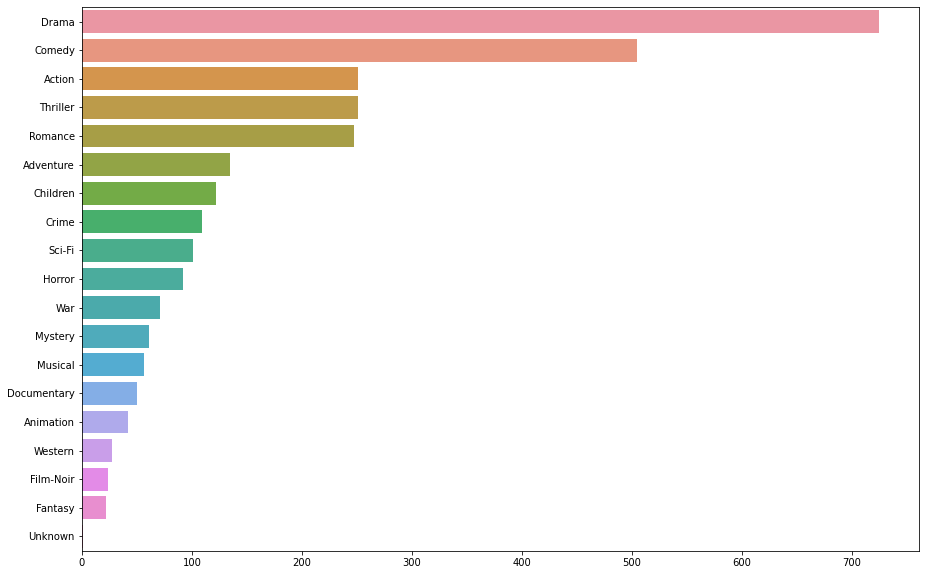

In [9]:
count = {}
for item in movies_df['label_genre']:
  for i in item:
    if i not in count:
      count[i] = 1
    else:
      count[i] += 1

count = dict(sorted(count.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(15, 10))
sns.barplot(x=list(count.values()), y=list(count.keys()))

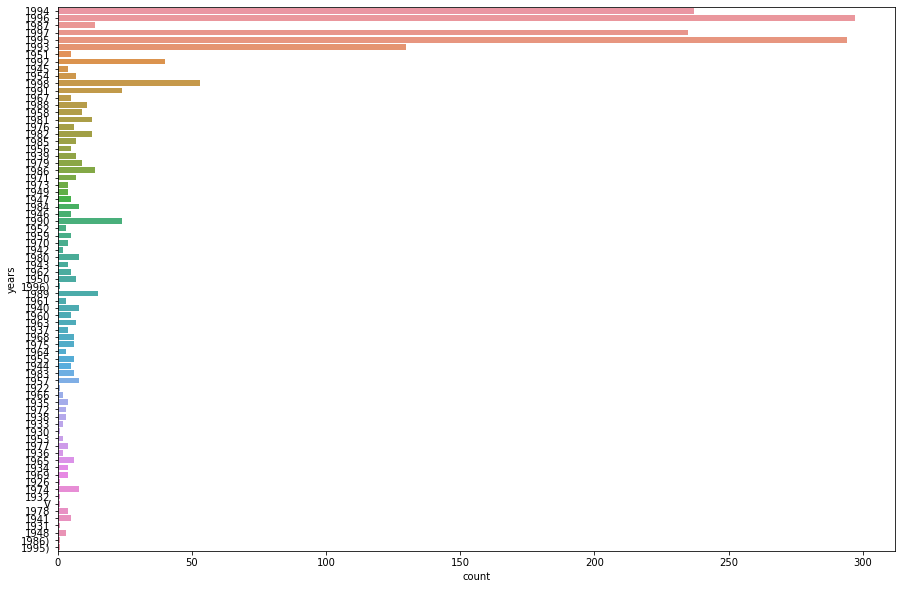

In [10]:
plt.figure(figsize=(15, 10))
sns.countplot(data=movies_df, y='years')

In [48]:
# Lets explore ratings data
ratings_df.sample(10)

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,label_genre
26173,25.0,[4],b'609',b'Father of the Bride (1950)',30.0,879991105,True,b'897',11,b'other',5.0,b'33484',[Comedy]
38249,35.0,"[0, 1, 15]",b'82',b'Jurassic Park (1993)',37.0,892550310,True,b'669',11,b'other',4.0,b'20009',"[Action, Adventure, Sci-Fi]"
39965,25.0,"[0, 5, 7]",b'806',b'Menace II Society (1993)',26.0,885873302,True,b'94',17,b'student',4.0,b'71457',"[Action, Crime, Drama]"
47029,25.0,[16],b'3',b'Four Rooms (1995)',31.0,875748068,True,b'63',14,b'marketing',2.0,b'75240',[Thriller]
5541,25.0,"[0, 15, 16]",b'195',"b'Terminator, The (1984)'",25.0,882342669,True,b'399',11,b'other',2.0,b'92374',"[Action, Sci-Fi, Thriller]"
1385,50.0,[4],b'42',b'Clerks (1994)',51.0,887923923,True,b'474',6,b'executive',4.0,b'93711',[Comedy]
8028,35.0,[7],b'87',b'Searching for Bobby Fischer (1993)',35.0,889665232,True,b'378',17,b'student',4.0,b'02859',[Drama]
85750,25.0,"[4, 7]",b'382',"b'Adventures of Priscilla, Queen of the Desert...",31.0,879519556,True,b'295',0,b'educator',5.0,b'50325',"[Comedy, Drama]"
43872,45.0,"[7, 14]",b'276',b'Leaving Las Vegas (1995)',49.0,884584817,True,b'141',12,b'programmer',1.0,b'36117',"[Drama, Romance]"
92849,18.0,[7],b'874',b'Career Girls (1997)',20.0,876696853,False,b'416',17,b'student',1.0,b'92626',[Drama]


In [50]:
ratings_df.sample(10)[['user_id', 'label_genre']]

,user_id,label_genre
29556,b'654',"[Comedy, Romance]"
83752,b'353',"[Drama, Sci-Fi]"
22479,b'592',"[Adventure, Thriller]"
45848,b'226',"[Comedy, Sci-Fi]"
84355,b'749',"[Adventure, Children, Drama]"
37296,b'393',"[Animation, Children, Musical]"
88333,b'82',"[Comedy, Drama]"
55342,b'200',[Comedy]
41367,b'664',"[Drama, Mystery]"
56072,b'873',[Comedy]


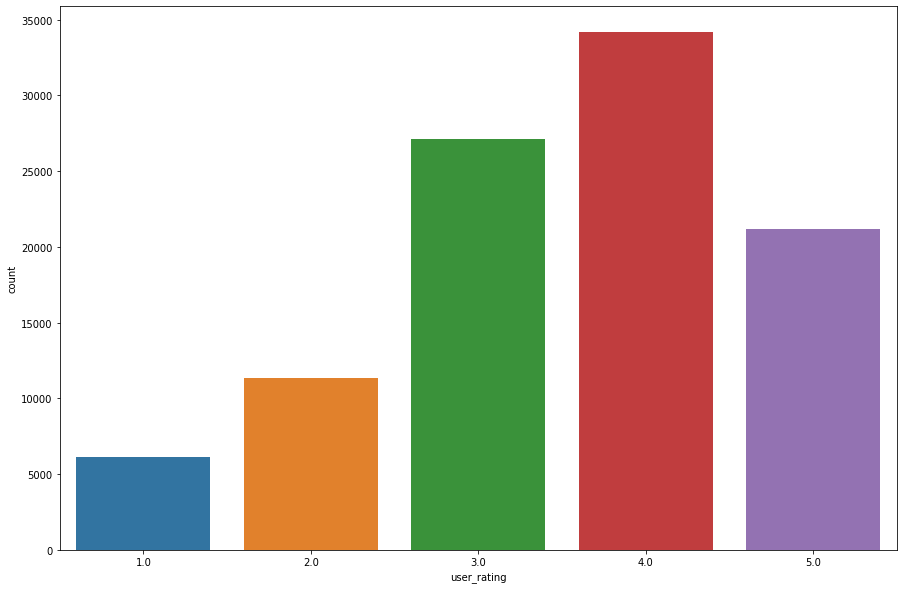

In [12]:
plt.figure(figsize=(15, 10))
sns.countplot(data=ratings_df, x='user_rating')

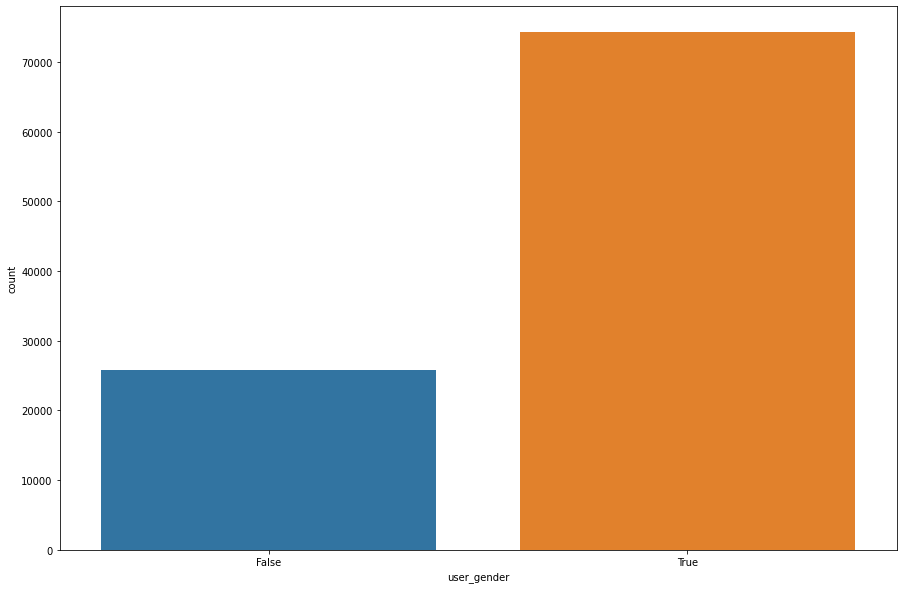

In [13]:
plt.figure(figsize=(15, 10))
sns.countplot(data=ratings_df, x='user_gender')

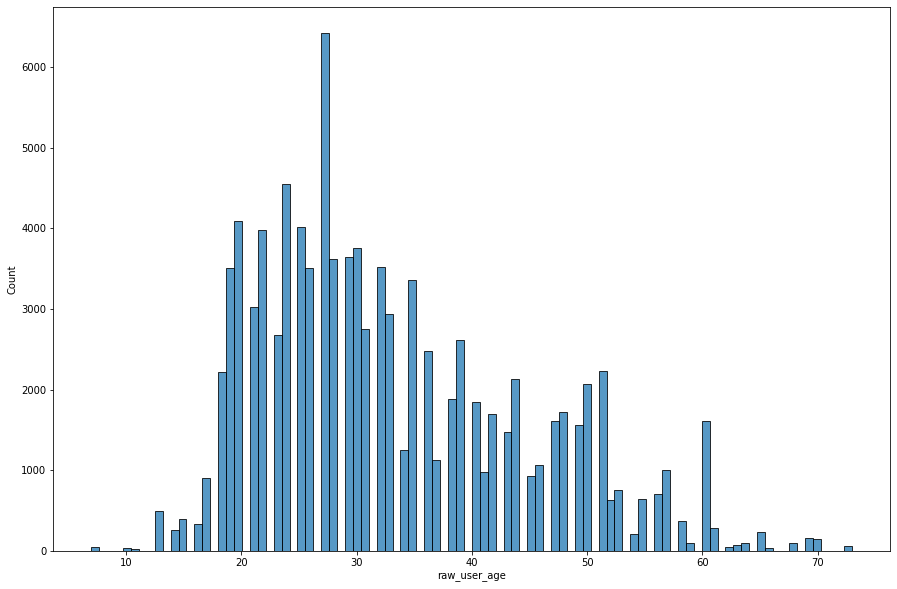

In [14]:
plt.figure(figsize=(15, 10))
sns.histplot(data=ratings_df, x='raw_user_age')

# Get data ready
- Split train data

In [15]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

In [16]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [17]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [18]:
unique_movie_titles[:10], unique_user_ids[:10]

(array([b"'Til There Was You (1997)", b'1-900 (1994)',
        b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
        b'2 Days in the Valley (1996)',
        b'20,000 Leagues Under the Sea (1954)',
        b'2001: A Space Odyssey (1968)',
        b'3 Ninjas: High Noon At Mega Mountain (1998)',
        b'39 Steps, The (1935)'], dtype=object),
 array([b'1', b'10', b'100', b'101', b'102', b'103', b'104', b'105',
        b'106', b'107'], dtype=object))

# Build model

In [19]:
emb_dim = 32

In [20]:
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None
    ),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, emb_dim)
])

In [22]:
movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None
    ),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, emb_dim)
])

In [23]:
metrics = tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model)
)

In [24]:
task = tfrs.tasks.Retrieval(
    metrics=metrics
)

In [26]:
# Compiled model
class MovielensReconModel(tfrs.Model):
  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features['user_id'])

    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, positive_movie_embeddings)

In [27]:
# Train model
model = MovielensReconModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [28]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [30]:
history = model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 10s 948ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0212 - factorized_top_k/top_10_categorical_accuracy: 0.0456 - factorized_top_k/top_50_categorical_accuracy: 0.1952 - factorized_top_k/top_100_categorical_accuracy: 0.3272 - loss: 65609.7443 - regularization_loss: 0.0000e+00 - total_loss: 65609.7443
Epoch 2/3
10/10 [==============================] - 10s 945ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0240 - factorized_top_k/top_10_categorical_accuracy: 0.0507 - factorized_top_k/top_50_categorical_accuracy: 0.2090 - factorized_top_k/top_100_categorical_accuracy: 0.3434 - loss: 65110.2670 - regularization_loss: 0.0000e+00 - total_loss: 65110.2670
Epoch 3/3
10/10 [==============================] - 9s 927ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy

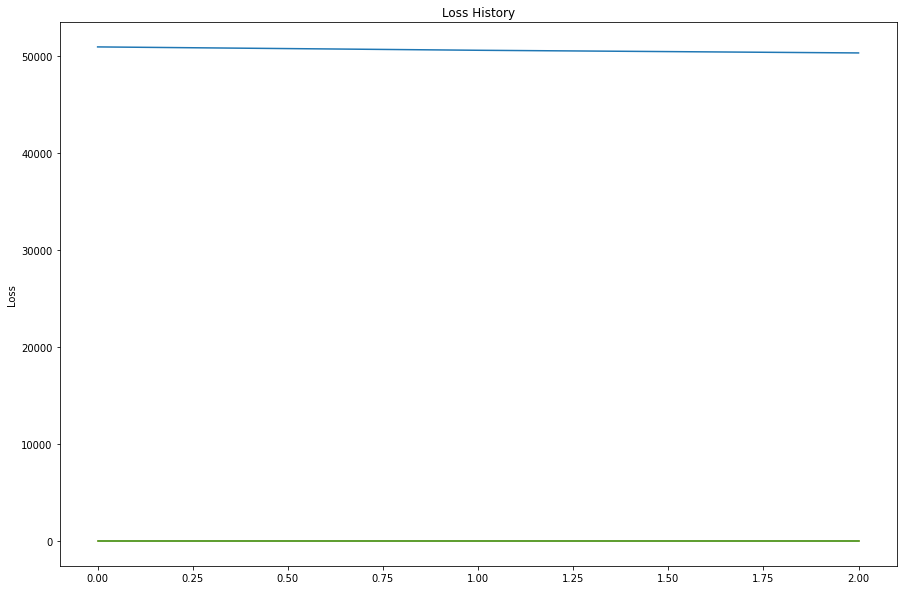

In [41]:
plt.figure(figsize=(15, 10))
plt.title('Loss History')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['factorized_top_k/top_1_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'])

In [42]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 5s 539ms/step - factorized_top_k/top_1_categorical_accuracy: 6.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0055 - factorized_top_k/top_10_categorical_accuracy: 0.0140 - factorized_top_k/top_50_categorical_accuracy: 0.1010 - factorized_top_k/top_100_categorical_accuracy: 0.2051 - loss: 31292.3770 - regularization_loss: 0.0000e+00 - total_loss: 31292.3770


{'factorized_top_k/top_100_categorical_accuracy': 0.2050500065088272,
 'factorized_top_k/top_10_categorical_accuracy': 0.014000000432133675,
 'factorized_top_k/top_1_categorical_accuracy': 0.0006500000017695129,
 'factorized_top_k/top_50_categorical_accuracy': 0.1010499969124794,
 'factorized_top_k/top_5_categorical_accuracy': 0.005499999970197678,
 'loss': 28400.859375,
 'regularization_loss': 0,
 'total_loss': 28400.859375}

# Inference
- Lets make a prediction and see the results
- But from the training results does not look good

In [43]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
    tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

In [51]:
_, titles = index(tf.constant(['654']))
print(f"Recommendations for user 654: {titles[0, :3]}")

Recommendations for user 654: [b'Bridges of Madison County, The (1995)' b'Rudy (1993)'
 b'Aristocats, The (1970)']


In [52]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

In [53]:
_, titles = scann_index(tf.constant(['654']))
print(f"Recommendations for user 654: {titles[0, :3]}")

Recommendations for user 654: [b'Grosse Pointe Blank (1997)' b'Bed of Roses (1996)'
 b'Men in Black (1997)']


# Save model

In [54]:
tf.saved_model.save(index, 'model', options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"]))

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [56]:
loaded = tf.saved_model.load('model')

# Pass a user id in, get top predicted movie titles back.
scores, titles = loaded(["654"])

print(f"Recommendations: {titles[0][:3]}")

Recommendations: [b'Grosse Pointe Blank (1997)' b'Men in Black (1997)' b'Out to Sea (1997)']
